Voice Synthesis: Generating Human Like Speech From Text \
Alfred Chinedu Okoronkwo \
CSCIE-89 - Deep Learning: Final Project

There are very good publicly available machine learning models that clone human voices. In this project, we will leverage a pre-trained model to clone the voice of a speaker and use it in in tts to translate a text to speech. Next, we denoise the generated audio file for better quality.

In [1]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from IPython.display import Audio

import torch
# print("After torch:", matplotlib.get_backend())

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device:", device)

from TTS.api import TTS
# print("After TTS:", matplotlib.get_backend())

%matplotlib inline
import librosa
# print("After librosa:", matplotlib.get_backend())

import noisereduce as nr
import soundfile as sf
# from scipy.signal import fftconvolve, butter, lfilter, filtfilt
from scipy.signal import butter, filtfilt
# from nara_wpe.wpe import wpe
# from scipy.signal import stft, istft
from sklearn.metrics.pairwise import cosine_distances
print("After noisereduce:", matplotlib.get_backend())

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3
# print("After noisereduce:", matplotlib.get_backend())

Using device: mps
After noisereduce: inline


## The Pre-trained Model - Your TTS

In [2]:
model = "tts_models/multilingual/multi-dataset/your_tts"

## The Speaker

In [3]:
speaker_wav = "./speakers/wavs/LJ001-0001.wav"

In [4]:
Audio(speaker_wav)

## Zero-Shot Cloning with TTS

In [5]:
# Text was generated by chatGPT
text = """
The morning sun streamed through the window, casting warm golden light across the room. Birds chirped cheerfully outside, adding a lively soundtrack to the quiet start of the day. It was the perfect moment to enjoy a cup of coffee and plan the day ahead.
"""

In [6]:
out_dir = "./example_output"
os.makedirs(out_dir, exist_ok=True)

In [7]:
out_file_name = "lj001_0001.wav"
gen_tts_filename = os.path.join(out_dir, out_file_name)
tts = TTS(model)
tts.tts_to_file(
    text=text, file_path=gen_tts_filename, language="en", speaker_wav=speaker_wav
)

 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-

'./example_output/lj001_0001.wav'

### The Generated Audio

In [8]:
Audio(gen_tts_filename)

### Denoising Utilities

In [9]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def highpass_filter(data, cutoff, fs):
    b, a = butter_highpass(cutoff, fs)
    y = filtfilt(b, a, data)
    return y

def bandpass_filter(data, lowcut, highcut, fs):
    b, a = butter_bandpass(lowcut, highcut, fs)
    y = filtfilt(b, a, data)
    return y

def normalize_audio(data):
    return data / np.max(np.abs(data))

def denoise_audio(
    input_path, 
    output_path, 
    cutoff=150, 
    lowcut=None, 
    highcut=None,
    noise_duration=0.5, 
    normalize=True, 
    plot=False
):
    data, sr = sf.read(input_path)

    # Stereo handling
    if len(data.shape) > 1:
        denoised = np.zeros_like(data)
        for ch in range(data.shape[1]):
            # Adaptive noise sample: first few seconds or user-defined
            noise_sample = data[0:int(sr*noise_duration), ch]
            denoised[:, ch] = nr.reduce_noise(y=data[:, ch], y_noise=noise_sample, sr=sr)
    else:
        noise_sample = data[0:int(sr*noise_duration)]
        denoised = nr.reduce_noise(y=data, y_noise=noise_sample, sr=sr)

    # Apply high-pass or band-pass filter
    if lowcut is not None and highcut is not None:
        cleaned = bandpass_filter(denoised, lowcut, highcut, fs=sr)
    else:
        cleaned = highpass_filter(denoised, cutoff=cutoff, fs=sr)

    # Normalize
    if normalize:
        cleaned = normalize_audio(cleaned)

    # Save output
    sf.write(output_path, cleaned, sr)
    print(f"Audio cleaned and saved as {output_path}")

    # plt.figure(figsize=(12, 4))
    # if len(data.shape) > 1:
    #     plt.plot(data[:, 0], alpha=0.5, label="TTS Audio (Left)")
    #     plt.plot(cleaned[:, 0], alpha=0.8, label="Denoised TTS Audio (Left)")
    # else:
    #     plt.plot(data, alpha=0.5, label="TTS Audion")
    #     plt.plot(cleaned, alpha=0.8, label="Denoised TTS Audio")
    # plt.legend()
    # plt.title("Audio Denoising Comparison")
    # plt.show()


In [10]:
denoised_filename = "./denoised/lj001_0001.wav"
denoise_audio(gen_tts_filename, denoised_filename, plot=True)

Audio cleaned and saved as ./denoised/lj001_0001.wav


### The De-noised Audio

In [11]:
Audio(denoised_filename)

## Comparing The Audios

In [12]:
def plot_waveforms(tts_audio_path, denoised_audio_path):
    y1, sr1 = sf.read(tts_audio_path)
    y2, sr2 = sf.read(denoised_audio_path)

    # Convert to mono if stereo
    if y1.ndim > 1:
        y1 = y1.mean(axis=1)
    if y2.ndim > 1:
        y2 = y2.mean(axis=1)

    # Align length
    min_len = min(len(y1), len(y2))
    y1, y2 = y1[:min_len], y2[:min_len]

    t = np.linspace(0, min_len / sr1, min_len)

    plt.figure(figsize=(12, 4))
    plt.plot(t, y1, label="TTS Generated Audio")
    plt.plot(t, y2, label="Denoised Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Waveform Comparison")
    plt.legend()
    plt.show()

### Waveform Comparison of TTS Generated Audio and The Denoised TTS Generated Audio

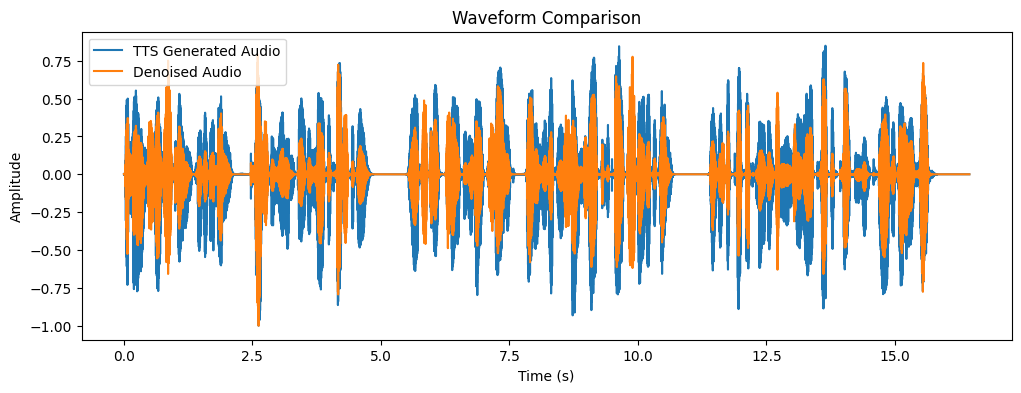

In [13]:
plot_waveforms(gen_tts_filename, denoised_filename)

## Compare with the Original Speaker Audio

In [14]:
def extract_features(path, sr=16000):
    y, sr = librosa.load(path, sr=sr, mono=True)

    # MFCCs (timbre)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = mfcc.mean(axis=1)

    # Pitch (F0)
    f0, _, _ = librosa.pyin(
        y,
        fmin=librosa.note_to_hz("C2"),
        fmax=librosa.note_to_hz("C7")
    )
    f0 = f0[~np.isnan(f0)]
    f0_mean = np.mean(f0) if len(f0) > 0 else 0

    # RMS energy
    rms = librosa.feature.rms(y=y).mean()

    # Spectral centroid (brightness)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()

    return np.concatenate([
        mfcc_mean,
        [f0_mean, rms, centroid]
    ])


In [15]:
def normalize(x, ref):
    return 1 - (np.abs(x - ref) / (np.abs(ref) + 1e-6))

def compare_audio_plots(
    speaker_wav,
    tts_wav,
    denoised_tts_wav,
    extra_wav=None,
    extra_label="Extra Audio"
):
    # Extract features
    ref = extract_features(speaker_wav)
    cand_a = extract_features(tts_wav)
    cand_b = extract_features(denoised_tts_wav)
    
    candidates = [cand_a, cand_b]
    labels = ["TTS Audio", "Denoised TTS Audio"]

    # Include extra file if provided
    if extra_wav is not None:
        cand_extra = extract_features(extra_wav)
        candidates.append(cand_extra)
        labels.append(extra_label)

    sims = [normalize(c, ref) for c in candidates]

    feature_labels = [f"MFCC{i}" for i in range(1, 14)] + ["Pitch", "Energy", "Brightness"]
    angles = np.linspace(0, 2*np.pi, len(feature_labels), endpoint=False)
    angles = np.concatenate([angles, [angles[0]]])  # Close the loop
    sims = [np.concatenate([s, [s[0]]]) for s in sims]  # Close the loop

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    
    colors = ["blue", "red", "green"][:len(labels)]
    for sim, lbl, color in zip(sims, labels, colors):
        ax.plot(angles, sim, label=lbl, color=color)
    
    ax.plot(angles, [1]*len(angles), linestyle="--", color="gray", label="Reference")
    ax.set_thetagrids(angles[:-1] * 180 / np.pi, feature_labels)
    ax.set_title("Feature Similarity to Reference (Higher is Better)")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(labels)+1)
    plt.show()


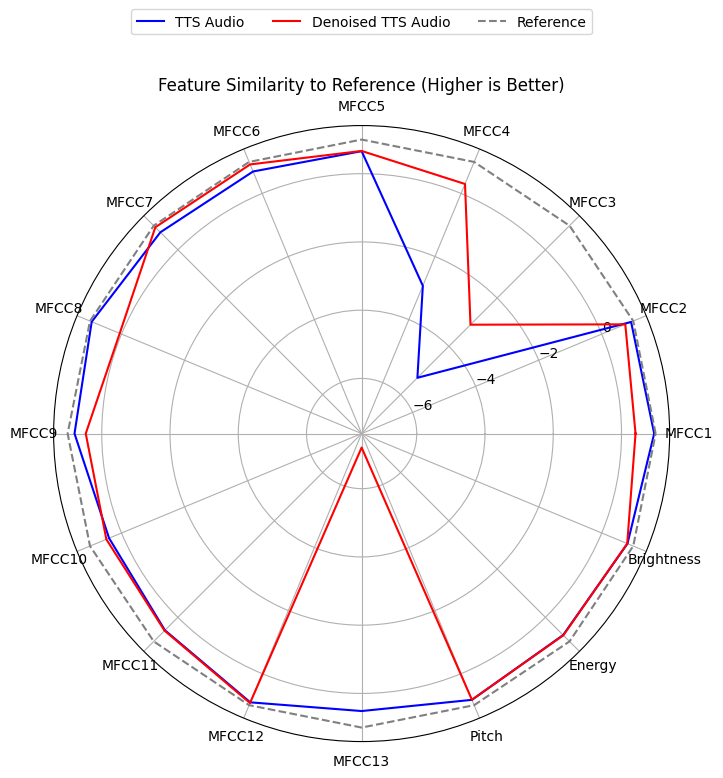

In [16]:
compare_audio_plots(speaker_wav, gen_tts_filename, denoised_filename)

### Preserve Pitch and Harmonics in the Audio

In [17]:
def denoise_audio_v2(
    input_path,
    output_path,
    noise_duration=0.5,
    normalize=True
):
    """
    Denoise an audio file while preserving pitch and harmonic content.
    
    Args:
        input_path (str): Path to the input audio file.
        output_path (str): Path to save the cleaned audio.
        noise_duration (float): Duration (in seconds) to use for noise estimation.
        normalize (bool): Whether to normalize output audio.
        plot (bool): Whether to plot waveform comparison.
    """
    data, sr = sf.read(input_path)

    if len(data.shape) > 1:  # Stereo
        denoised = np.zeros_like(data)
        for ch in range(data.shape[1]):
            noise_sample = data[0:int(sr*noise_duration), ch]
            denoised[:, ch] = nr.reduce_noise(
                y=data[:, ch],
                y_noise=noise_sample,
                sr=sr,
                stationary=False  # preserves tonal content
            )
    else:  # Mono
        noise_sample = data[0:int(sr*noise_duration)]
        denoised = nr.reduce_noise(
            y=data,
            y_noise=noise_sample,
            sr=sr,
            stationary=False
        )

    if normalize:
        denoised = normalize_audio(denoised)

    sf.write(output_path, denoised, sr)
    print(f"Audio cleaned and saved as {output_path}")

In [18]:
denoised_filename_v2 = "./denoised/lj001_0001_v2.wav"
denoise_audio_v2(gen_tts_filename, denoised_filename_v2)

Audio cleaned and saved as ./denoised/lj001_0001_v2.wav


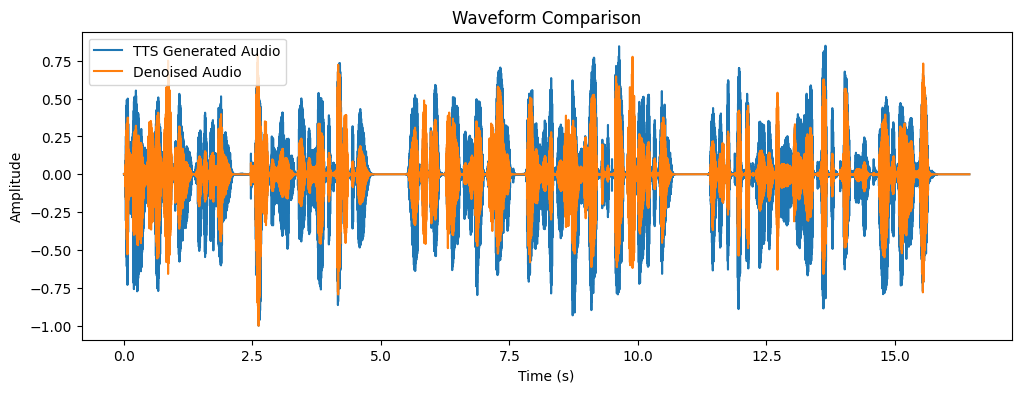

In [19]:
plot_waveforms(gen_tts_filename, denoised_filename_v2)

In [20]:
Audio(denoised_filename_v2)

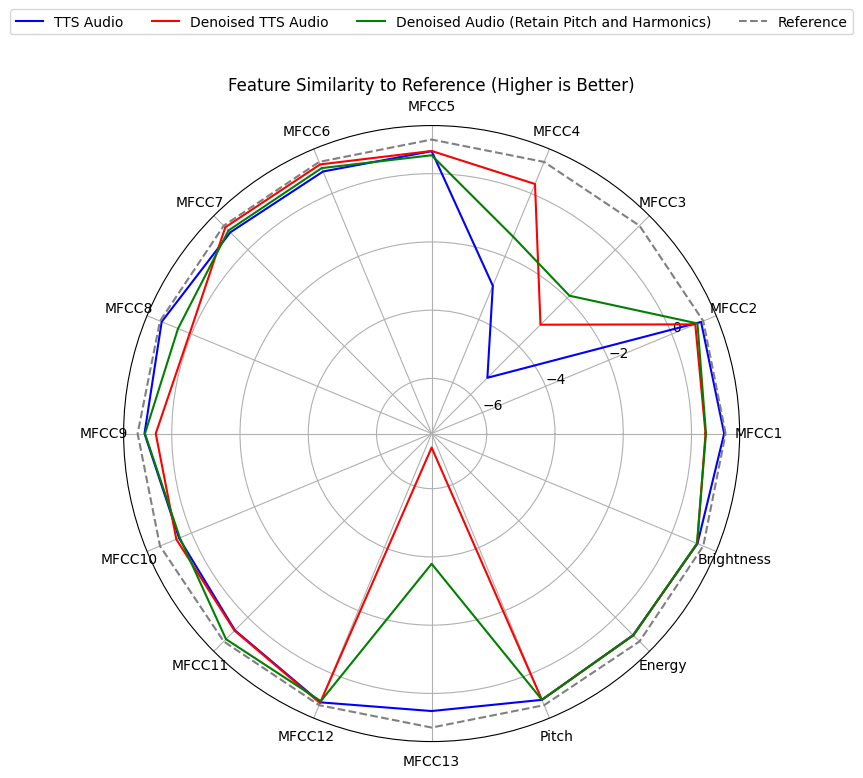

In [21]:
compare_audio_plots(
    speaker_wav, 
    gen_tts_filename, 
    denoised_filename,
    denoised_filename_v2,
    "Denoised Audio (Retain Pitch and Harmonics)"
)